<a href="https://colab.research.google.com/github/pjjongho/Colab_AD/blob/main/FPS%20Abnormal%20User%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Chapter 06]**  
**┗ 서바이벌 FPS 게임 버그 유저 탐색**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「이상 데이터 정의」
* 🥇Session 3 - 「이상 탐지 모델링」

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1LHmfXoXMGp6IyNDV8tY6HmwQBAKRrwqb/Step 3. 다양한 산업 도메인에서의 실전 이상탐지 실습/Chapter 06. 서바이벌 FPS 게임 버그 유저 탐색'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🎮

```
A사는 FPS 게임을 운영하고 있다. 최근 글로벌 서버를 오픈함에 있어 많은 신규 유저들이 진입하고 있다. 이와 동시에 버그유저들도 같이 증가하고 있어 게임 운영에   
많은 어려움을 느끼고 있는 상황이다. A사는 플레이어의 게임 플레이 데이터를 수집하여 버그 의심 유저로 판단되는 유저들을 색출하고 패널티를 부여하려고 한다.

```  

> **데이터 살펴보기**

* FPS 게임 플레이 데이터
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|ID |ID|
|groupId |그룹ID|
|matchId |경기ID|
|assists |서포트횟수|
|boosts |부스트 아이템 사용횟수|
|damageDealt |총 입힌 데미지|
|DBNOs |적을 기절시킨 횟수|
|headshotKills |헤드샷킬수|
|heals |heal 아이템 사용횟수|
|killPlace |적을제압한위치|
|killPoints |적제압포인트|
|kills |적 제압횟수|
|killStreaks |가장 많이 적 제압횟수|
|longestKill |멀리서 적 제압횟수|
|maxPlace |최악의배치넘버|
|numGroups |그룹넘버|
|revives |부활횟수|
|rideDistance |이동수단 타고 이동거리|
|roadKills |이동수단으로 적 제압횟수|
|swimDistance|수영한거리|
|teamKills |같은팀 제압횟수|
|vehicleDestroys|자동차 파괴횟수|
|walkDistance|도보이동거리|
|weaponsAcquired|무기 획득횟수|
|winPoints|승점|
|winPlacePerc|승률|




In [3]:
# ▶ pd.set option
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
df_train = pd.read_csv("chapter06_df_train.csv")
df_test = pd.read_csv("chapter06_df_test.csv")

df = pd.concat([df_train, df_test], axis=0)
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,1050,2,1,65.32,29,28,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,1072,1,1,13.55,26,23,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,1404,0,0,0.00,28,28,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,1069,0,0,0.00,97,94,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,1034,0,0,0.00,47,41,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 글로벌 오픈에 따른 버그 이용 유저 증가
▶ 신규 진입 유저 및 기존 이용 유저 이탈률 증가
```  

> **기대효과**

```
▶ 버그 사용 의심 유저 색출 및 게임 정상화
▶ 유저(신규, 기존) 고객 불만 감소 및 사용율 증대
```

> **해결방안**

```
▶ 버그 의심 유저 행동 패턴을 정의하고, 이상 유저 검출
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 게임 플레이 데이터 활용 이상 유저 정의
▶ Session 3 🥇
 - 이상 탐지 모델링 수행
```

> **성과측정**  

```
▶ 모델 활용 전/후 버그 신고 건수 비교
▶ 모델 활용 전/후 신규 사용자 증감 비교
▶ 모델 활용 전/후 기존 사용자 이탈률 비교
```

> **현업적용**  

```
▶ 게임 플레이 데이터 수집 및 이상 탐지 Model에 Input
▶ 버그 의심 유저 검출 시 해당 유저 상세 분석
▶ 버그 유저 판단되면 제한 조치 실행
```

> **주요 코드 미리 살펴보기**  

```
▶ Session 1 → pd.cut, .nunique(), sns.boxplot(), sns.jointplot()
▶ Session 2 → sns.scatterplot(), sns.distplot()
▶ Session 3 → .quantile(0.10), df['_totalDistance'].quantile(0.10)) & (df['_headshot_rate']  >= 0.8)]
```

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  

In [5]:
# ▶ Data 형태 확인
print('df :', df.shape)

df : (6225249, 26)


In [6]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6225249 entries, 0 to 1867912
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               int64  
 1   groupId          int64  
 2   matchId          int64  
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  maxPlace         int64  
 15  numGroups        int64  
 16  revives          int64  
 17  rideDistance     float64
 18  roadKills        int64  
 19  swimDistance     float64
 20  teamKills        int64  
 21  vehicleDestroys  int64  
 22  walkDistance     float64
 23  weaponsAcquired  int64  
 24  winPoints        int64  
 25  winPlacePerc     float64
dtypes: float64(6), int64(20)
memory usage: 1.3 GB


In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

Id                       0
groupId                  0
matchId                  0
assists                  0
boosts                   0
damageDealt              0
DBNOs                    0
headshotKills            0
heals                    0
killPlace                0
killPoints               0
kills                    0
killStreaks              0
longestKill              0
maxPlace                 0
numGroups                0
revives                  0
rideDistance             0
roadKills                0
swimDistance             0
teamKills                0
vehicleDestroys          0
walkDistance             0
weaponsAcquired          0
winPoints                0
winPlacePerc       1867913
dtype: int64


In [ ]:
# ▶ Null 값 존재 row 확인
df[df['winPlacePerc'].isna()].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,47734,1659463,47734,0,0,100.0,1,0,0,59,1000,0,0,0.000,50,45,0,0.0,0,0.0,1,0,421.50,7,1500,NaN
1,47735,1659508,47735,0,1,400.0,2,0,3,9,1200,4,2,15.420,48,47,1,0.0,0,0.0,0,0,655.80,4,1526,NaN
2,47736,1659555,47736,0,0,0.0,0,0,0,72,1216,0,0,0.000,29,28,0,0.0,0,0.0,0,0,74.58,1,1475,NaN
3,47737,1659621,47737,0,0,68.6,0,0,0,68,1177,0,0,0.000,97,92,0,0.0,0,0.0,0,0,167.20,2,1464,NaN
4,47738,1659675,47738,0,1,370.5,3,0,1,45,1013,1,1,5.968,27,26,0,0.0,0,0.0,0,0,146.70,3,1505,NaN


In [ ]:
# ▶ 승률 없는 데이터는 삭제
df = df.dropna()
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [ ]:
# ▶ Outlier 확인
df.describe()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06
mean,3.102678e+06,1.024777e+06,2.385539e+04,2.656320e-01,9.636856e-01,1.329033e+02,6.901455e-01,2.385866e-01,1.187169e+00,4.703440e+01,1.080898e+03,9.344958e-01,5.547651e-01,1.987925e+01,4.207759e+01,4.058035e+01,1.649345e-01,4.238835e+02,2.557985e-03,4.136261e+00,1.388555e-02,5.146264e-03,1.055122e+03,3.457289e+00,1.500504e+03,4.718663e-01
std,1.797477e+06,6.967197e+05,1.378227e+04,6.342160e-01,1.560643e+00,1.699439e+02,1.191514e+00,6.103033e-01,2.366389e+00,2.732772e+01,1.237119e+02,1.566192e+00,7.223452e-01,4.586552e+01,2.267769e+01,2.206667e+01,4.672004e-01,1.222927e+03,6.346679e-02,2.757015e+01,1.329266e-01,7.425362e-02,1.116122e+03,2.402109e+00,4.253571e+01,3.079147e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.550000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.500000e+02,0.000000e+00
25%,1.537746e+06,4.741378e+05,1.191400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,2.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.334000e+02,2.000000e+00,1.491000e+03,1.979000e-01
50%,3.110606e+06,9.430320e+05,2.383700e+04,0.000000e+00,0.000000e+00,8.776000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,1.029000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,2.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.732000e+02,3.000000e+00,1.500000e+03,4.583000e-01
75%,4.657295e+06,1.418544e+06,3.580100e+04,0.000000e+00,1.000000e+00,1.884000e+02,1.000000e+00,0.000000e+00,1.000000e+00,7.000000e+01,1.126000e+03,1.000000e+00,1.000000e+00,1.629000e+01,4.900000e+01,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.808000e+03,5.000000e+00,1.510000e+03,7.407000e-01
max,6.224522e+06,2.700605e+06,4.773300e+04,2.000000e+01,1.800000e+01,6.384000e+03,6.300000e+01,2.600000e+01,5.900000e+01,1.000000e+02,2.047000e+03,6.000000e+01,1.400000e+01,1.323000e+03,1.000000e+02,1.000000e+02,4.100000e+01,4.839000e+04,4.200000e+01,5.286000e+03,6.000000e+00,5.000000e+00,1.730000e+04,7.600000e+01,1.923000e+03,1.000000e+00


### · Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [ ]:
# ▶ 기본 정보 확인
for i in ['Id','groupId','matchId']:
    print(f'unique [{i}] count:', df[i].nunique())

unique [Id] count: 4357336
unique [groupId] count: 1888732
unique [matchId] count: 47734


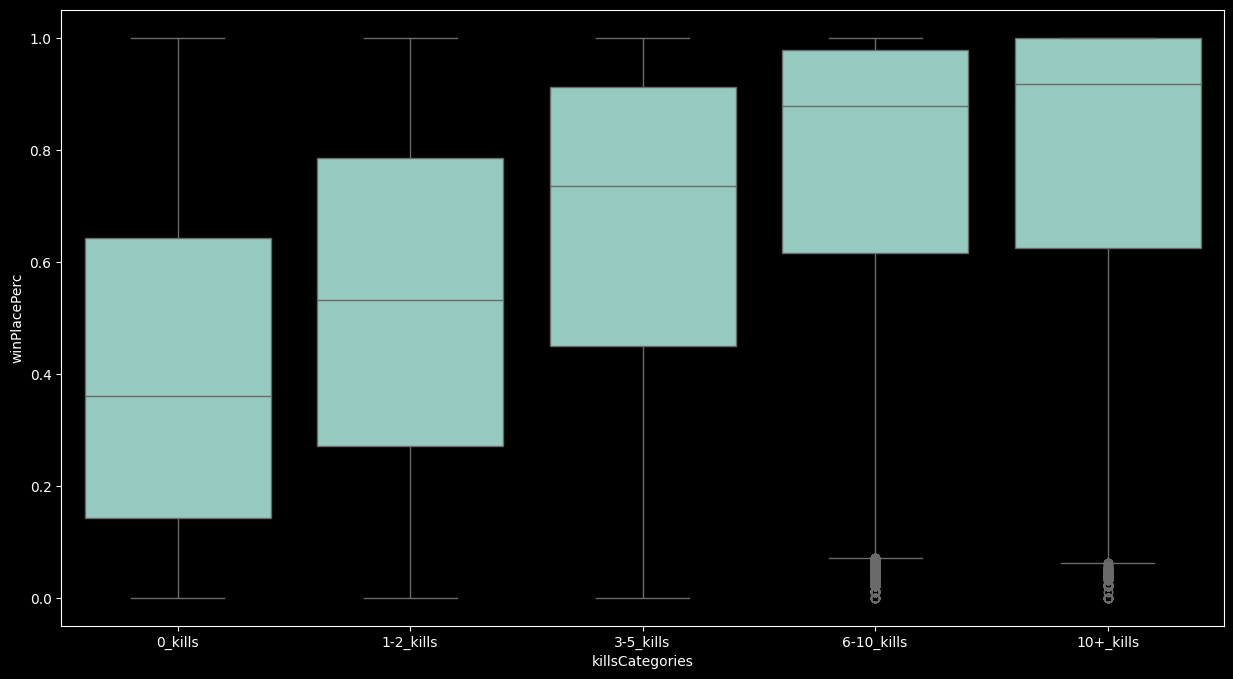

In [9]:
# ▶ 연속형 변수 binning 후 'val' box plot 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

kills = df.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1,0,2,5,10,60], labels= ['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])
plt.figure(figsize=(15,8))
sns.boxplot(x='killsCategories', y='winPlacePerc', data=kills)
plt.show()

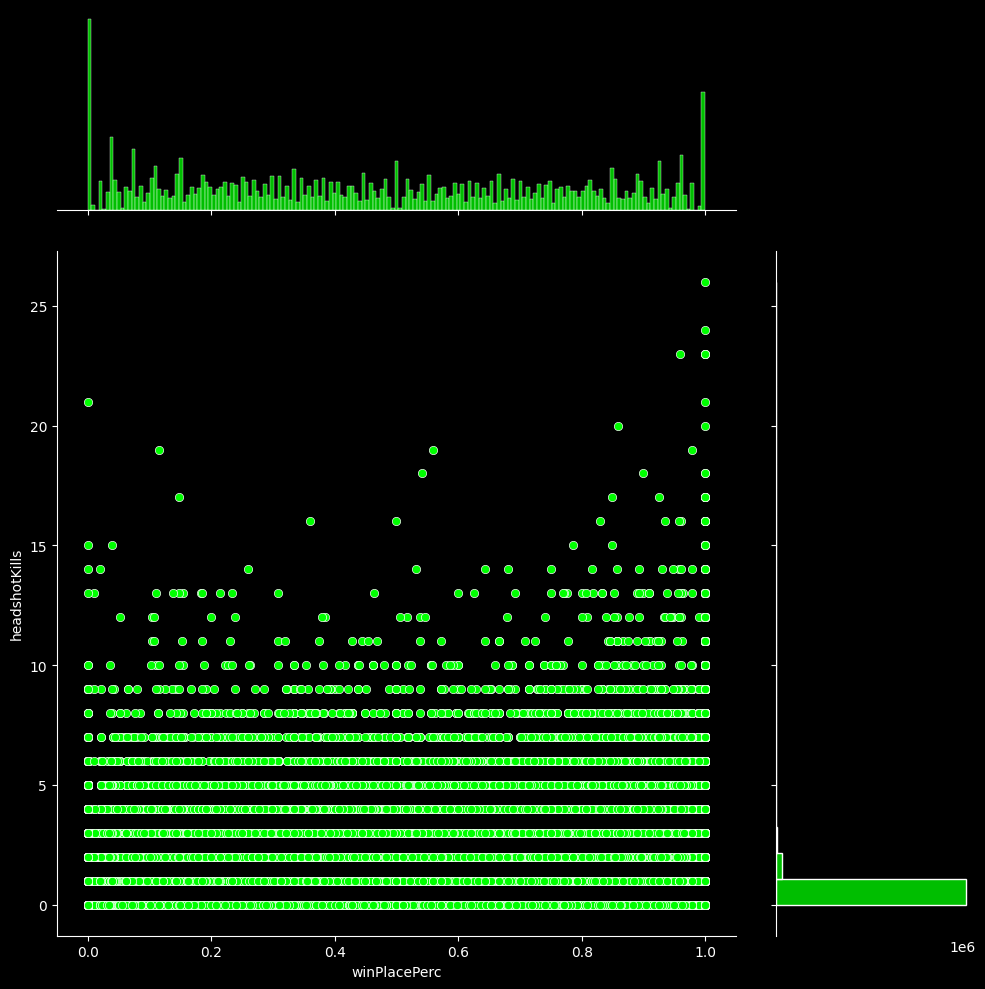

In [10]:
# ▶ Joint plot 통해서 va1, va2 관계 확인
sns.jointplot(x='winPlacePerc',y='headshotKills', data=df, height=10, ratio=3, color="lime")
plt.show()

## **🥈Session 2**  
**┗ 이상 데이터 정의**  
---
* 가설을 수립하고, 데이터로 가볍게 검증

### · ① Automated aiming
---

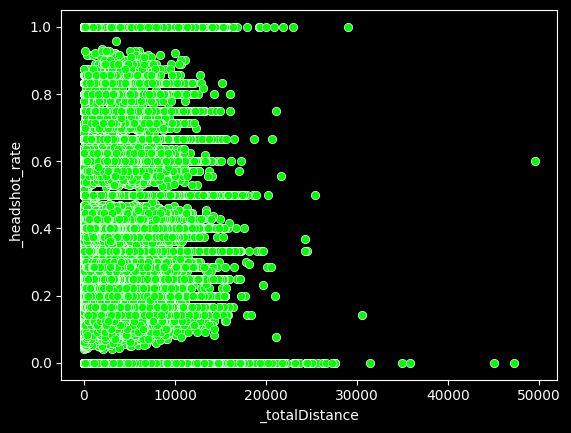

In [11]:
# ▶ Total 이동 거리는 낮은데, headshot 비율이 높은 유저가 존재할까?
df['_totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

df['_headshot_rate'] = df['headshotKills']/df['kills']
df['_headshot_rate'] = df['_headshot_rate'].fillna(0)

sns.scatterplot(x='_totalDistance',y='_headshot_rate', data=df, color="lime");

### · ② Inhuman Kills
---

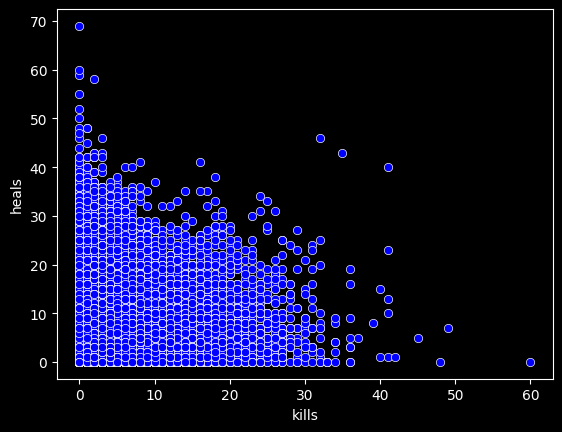

In [12]:
# ▶ heal 없이 Kill 수가 많은 버그 유저가 존재할까?
sns.scatterplot(x='kills',y='heals', data=df, color="blue");

### · ③ 100% Headshot Kills
---

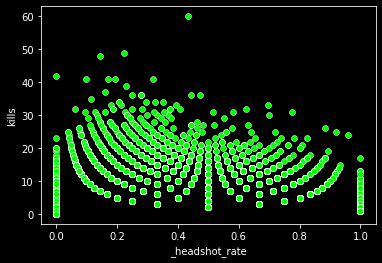

In [ ]:
# ▶ 100% Headshot만 하는 유저가 존재할까?
sns.scatterplot(x='_headshot_rate',y='kills', data=df, color="lime");

### · ④ Anomalies in Heals
---

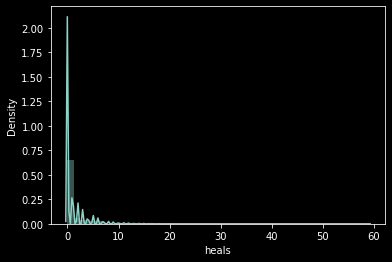

In [ ]:
# ▶ 치료제(Heal)을 너무 많이 쓰는 유저가 존재할까?
sns.distplot(df['heals']);

### · ⑤ Without moving & WeaponsAcquired
---

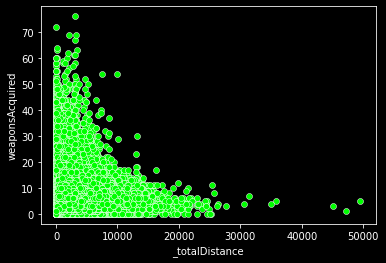

In [ ]:
# ▶ 이동없이 무기를 획득하는 유저가 존재할까?
sns.scatterplot(x='_totalDistance',y='weaponsAcquired', data=df, color="lime");

## **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · ① Automated aiming - analyze
---

In [ ]:
# ▶ _totalDistance, _headshot_rate 활용
# ▶ 10분위수(decile) : 내림 or 오름차순으로 정렬했을 때 10등분으로 데이터를 나눔

df_1 = df[(df['_totalDistance'] <= df['_totalDistance'].quantile(0.10)) & (df['_headshot_rate']  >= 0.8)]
print(len(df_1))
df_1.head()

9276


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
200,200,445186,200,0,0,240.2,1,1,0,41,1133,1,1,1.153,28,28,0,0.0,0,0.0,0,0,31.20,1,1481,0.0000,31.20,1.0
403,403,1337806,403,0,0,249.2,1,1,0,34,1326,1,1,4.841,38,35,0,0.0,0,0.0,0,0,32.71,1,1447,0.0000,32.71,1.0
784,784,2606376,784,0,0,189.2,0,1,0,42,1093,1,1,34.690,96,94,0,0.0,0,0.0,0,0,35.39,1,1477,0.2000,35.39,1.0
1441,1441,197195,1441,0,0,100.0,0,1,0,33,1024,1,1,36.790,96,95,0,0.0,0,0.0,0,0,31.32,1,1484,0.1158,31.32,1.0
1565,1565,250485,1565,0,0,100.0,1,1,0,33,1000,1,1,6.801,20,20,0,0.0,0,0.0,0,0,35.17,1,1500,0.1053,35.17,1.0


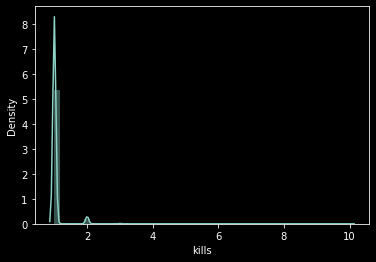

In [ ]:
# ▶ 너무 많은 데이터가 존재하므로, kill 수 분포 확인을 통해 그 중 더 이상한 데이터 탐색
sns.distplot(df_1['kills']);

In [ ]:
df['_totalDistance'].quantile(0.10), df['_totalDistance'].quantile(0.90)

(37.89, 3812.67)

In [ ]:
# ▶ 버그 의심 유저 검출
df_1[df_1['kills'] > 6][['kills', '_totalDistance', '_headshot_rate']]

,kills,_totalDistance,_headshot_rate
500360,8,0.00,0.875000
524698,10,30.83,0.800000
1177100,7,0.00,0.857143
2383933,10,0.00,0.800000
3277980,7,14.52,0.857143


### · ② Inhuman Kills - analyze
---

In [ ]:
# ▶ 평균 적인 Heal 횟수
df[['heals', 'kills']].describe()

,heals,kills
count,4.357336e+06,4.357336e+06
mean,1.187169e+00,9.344958e-01
std,2.366389e+00,1.566192e+00
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00
max,5.900000e+01,6.000000e+01


In [ ]:
# ▶ quantile(0.90)로 구분하기에는, 너무 적은 숫자의 Kill수
df['heals'].quantile(0.10), df['kills'].quantile(0.90)

(0.0, 3.0)

In [ ]:
df['kills'].mean()+3*df['kills'].std()

5.633072738084219

In [ ]:
# ▶ heal 0회, kill수는 평균 * 3std 이상 유저 확인
df_2 = df[(df['heals'] <= df['heals'].quantile(0.10)) & (df['kills']  >= df['kills'].mean()+3*df['kills'].std())]
print(len(df_2))
df_2[['heals', 'kills']]

8238


,heals,kills
79,0,7
161,0,7
531,0,16
745,0,7
976,0,6
...,...,...
4354081,0,7
4355347,0,8
4356162,0,6
4356264,0,8


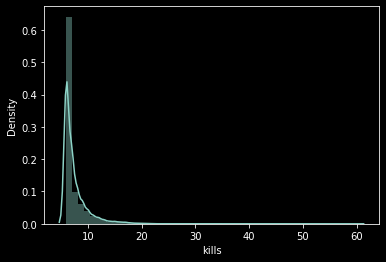

In [ ]:
# ▶ kill 수 분포 확인
sns.distplot(df_2['kills']);

In [ ]:
# ▶ 버그 의심 유저 검출
df_2[df_2['kills'] > 30][['kills', 'heals']].sort_values(by=['kills'], ascending =False)

,kills,heals
910050,60,0
74095,48,0
455912,36,0
88198,34,0
34674,33,0
319149,33,0
722495,33,0
4138946,33,0
409678,32,0
671890,32,0


### · ③ 100% Headshot Kills - analyze
---

In [ ]:
# ▶ headshot 100% 유저 탐색
df_3 = df[df['_headshot_rate'] == 1]
print(len(df_3))
df[df['_headshot_rate'] == 1].head()

266984


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
1,1,440875,1,1,0,37.65,1,1,0,45,1072,1,1,13.550,26,23,0,0.0,0,0.00,0,0,119.6,3,1511,0.0400,119.60,1.0
10,10,45059,10,0,1,166.00,0,1,1,35,1000,1,1,31.130,98,96,0,0.0,0,0.00,0,0,184.5,3,1500,0.4536,184.50,1.0
32,32,1010453,32,0,3,214.90,1,2,4,19,1047,2,1,127.000,49,48,0,1576.0,0,0.00,0,0,1526.0,3,1502,0.7292,3102.00,1.0
33,33,1054979,33,0,0,166.20,1,1,0,37,1281,1,1,1.657,30,30,0,0.0,0,0.00,0,0,133.1,2,1544,0.2414,133.10,1.0
50,50,1802026,50,0,3,360.30,3,2,15,15,1046,2,1,4.853,26,26,0,0.0,0,75.86,0,0,2669.0,6,1480,0.6800,2744.86,1.0


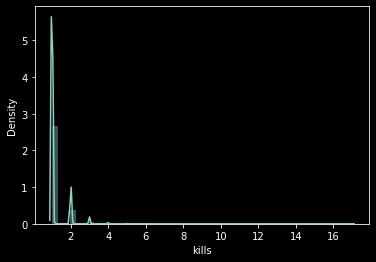

In [ ]:
# ▶ kill 수 분포 확인
sns.distplot(df_3['kills']);

In [ ]:
df_3['kills'].describe()

count    266984.000000
mean          1.173804
std           0.479215
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          17.000000
Name: kills, dtype: float64

In [ ]:
df_3['kills'].mean()+3*df_3['kills'].std()

2.6114506424929758

In [ ]:
# ▶ 버그 의심 유저 검출
df_3[df_3['kills'] > 10][['kills', '_headshot_rate']].sort_values(by=['kills'], ascending =False)

,kills,_headshot_rate
3902972,17,1.0
2411348,13,1.0
3201166,13,1.0
3409867,13,1.0
4277997,12,1.0
458289,11,1.0
3204285,11,1.0
4242764,11,1.0


### · ④ Anomalies in Heals - analyze
---

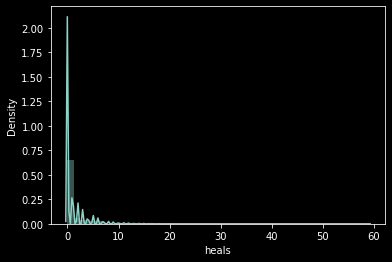

In [ ]:
# ▶ heal 아이템 사용횟수 분포 확인
sns.distplot(df['heals']);

In [ ]:
df['heals'].describe()

count    4.357336e+06
mean     1.187169e+00
std      2.366389e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.900000e+01
Name: heals, dtype: float64

In [ ]:
# ▶ 버그 의심 유저 검출
df[df['heals']>50]['heals']

271303     55
721128     58
1546110    59
Name: heals, dtype: int64

### · ⑤ Without moving & WeaponsAcquired - analyze
---

In [ ]:
# ▶ 기준치 확인
df['_totalDistance'].quantile(0.10), df['weaponsAcquired'].quantile(0.90)

(37.89, 6.0)

In [ ]:
# ▶ 이동거리는 적은데 무기 획득횟수가 많은 유저 탐색
df_5 = df[(df['_totalDistance'] <= df['_totalDistance'].quantile(0.10)) & (df['weaponsAcquired']  >= df['weaponsAcquired'].quantile(0.90))]
print(len(df_5))
df_5.head()

2265


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
896,896,2655234,896,0,0,296.1,2,0,1,17,1000,0,0,0.000,6,6,0,0.0,0,0.0,1,0,0.0,8,1500,0.2000,0.0,0.000000
1777,1777,344864,1777,6,0,1087.0,13,6,0,1,1000,12,2,1.539,4,4,5,0.0,0,0.0,0,0,0.0,9,1500,1.0000,0.0,0.500000
3260,3260,993275,3260,0,0,510.9,0,1,0,6,1000,6,1,46.490,14,10,0,0.0,0,0.0,0,0,0.0,10,1500,0.7692,0.0,0.166667
3405,3405,1057673,3405,3,1,1462.0,0,5,6,1,1000,15,1,83.780,7,7,0,0.0,0,0.0,0,0,0.0,29,1500,1.0000,0.0,0.333333
3612,3612,1148248,3612,12,0,2322.0,19,5,0,2,1000,18,2,87.960,5,5,0,0.0,0,0.0,0,0,0.0,33,1500,0.7500,0.0,0.277778


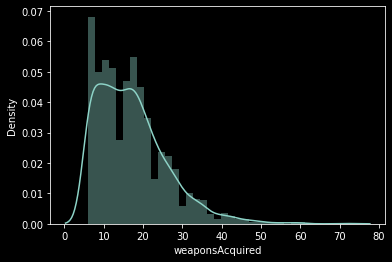

In [ ]:
# ▶ weaponsAcquired 수 분포 확인
sns.distplot(df_5['weaponsAcquired']);

In [ ]:
# ▶ 버그 의심 유저 검출
df_5[df_5['weaponsAcquired']>50][['_totalDistance', 'weaponsAcquired']].sort_values(by=['_totalDistance'])

,_totalDistance,weaponsAcquired
1525623,0.000,55
492307,8.284,58
455912,9.554,58
74113,18.790,53
817586,24.380,60
198722,24.570,60
444634,25.310,51
1072609,30.490,72
966854,34.290,55
550242,37.670,51
